# Final data preperation

In [1]:
# Necessary imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the marks processed data 
model_data = pd.read_csv('./model_data.csv', index_col=0)

In [3]:
# Line-up data needs to be added so home and away variables can be created

# Reading line up data
lineup_data = pd.read_csv('../initial_files/lineup_data.csv', index_col=0)
lineup_data = lineup_data.rename(columns={"MatchID": "Match_ID"})


# Creating home teams dataframe and dummy variable
home_teams = lineup_data.drop(['AwayTeam', 'PlayersHome','PlayersAway'], axis=1)
home_teams = home_teams.rename(columns={"HomeTeam": "Team_ID"})
home_teams['dummy_home'] = 1

# Creating away teams dataframe and dummy variable
away_teams = lineup_data.drop(['HomeTeam', 'PlayersHome','PlayersAway'], axis=1)
away_teams = away_teams.rename(columns={"AwayTeam": "Team_ID"})
away_teams['dummy_away'] = 1

# Merging home and away team dummy variables with model data
model_data = model_data.merge(home_teams, on=['Match_ID', 'Team_ID'], how='left')

# Fill nan's of dummy variables with 0
model_data['dummy_home'] = model_data['dummy_home'].fillna(0)

In [4]:
# Matchinfo data needs to be added so weather variable can be created

# Reading the weather data
weather_data = pd.read_csv('../initial_files/matchinfo_data.csv')
weather_data = weather_data.rename(columns={"MatchID": "Match_ID"})

# Dropping irrelevant columns
weather_data = weather_data.drop(['Unnamed: 0', 'FieldGeometryCm', 'FieldGeometryNormalized', 'TransmissionStartUTC',
                                 'LineupReportDeliveryTimeUTC', 'FullReportDeliveryTimeUTC', 'TrackingCameraPosition',
                                 'BenchesPosition', 'TrackingProviderTimeZoneOffset', 'VideoOffset',
                                 'ConsolidationStatus', 'UnreliableData', 'Attendance'], axis=1)

# Creating a bad weather variable if the weather is rainy, snowy, windy, foggy or humid and when pitch is wet or damp
weather_data['bad_weather'] = weather_data['WeatherCondition'].apply(lambda x: 1 if (x == 'Rain') else 0)
weather_data['bad_weather'] = weather_data['WeatherCondition'].apply(lambda x: 1 if (x == 'Foggy') else 0)
weather_data['bad_weather'] = weather_data['WeatherCondition'].apply(lambda x: 1 if (x == 'Snow') else 0)
weather_data['bad_weather'] = weather_data['FieldCondition'].apply(lambda x: 1 if (x == 'Wet') else 0)
weather_data['bad_weather'] = weather_data['FieldCondition'].apply(lambda x: 1 if (x == 'Damp') else 0)
weather_data['bad_weather'] = weather_data['WindSpeedKmh'].apply(lambda x: 1 if (x > 25) else 0)
weather_data['bad_weather'] = weather_data['HumidityPercentage'].apply(lambda x: 1 if (x > 90) else 0)

# Dropping columns now that dummy variable for weather has been created
weather_data = weather_data.drop(['HumidityPercentage', 'TemperatureCelsius', 'WindSpeedKmh', 'WeatherCondition',
                                 'FieldCondition'], axis=1)

# Merging weather data with model data
model_data = model_data.merge(weather_data, on=['Match_ID'], how='left')

In [5]:
# Hard coded the win odds and btts odds for all the games

# Read the betting data
betting_data = pd.read_excel('./betting_data.xlsx', index_col=0)

# Drop the unecessary columns
betting_data = betting_data.drop(['Win_Odds', 'Btts_Odds'], axis=1)

# Merging betting data with the model data
model_data = model_data.merge(betting_data, on=['Match_ID', 'Team_ID'], how='left')

# Data Cleaning

In [6]:
# Drop the 56 rows with NAN's
model_data = model_data.dropna()

In [7]:
# Two options

In [8]:
# Option 1: If goals more than 3, then it gets limited to 3
model_data.loc[model_data.Goals > 2, 'Goals'] = 3

In [9]:
# Option 2: removes any games with more than 4 goals
# model_data = model_data[model_data['Goals'] > 4]  

# Feaure Selection

In [10]:
# Dropping row reference
model_data = model_data.drop(['Match_ID', 'Team_ID'], axis=1)

# Making y-variable categorical so it is a classification problem and not regression
model_data['Goals'] = model_data['Goals'].apply(str)

# Need to store the model data in its current form
model_data1 = model_data

In [11]:
# Creating x and y
X = model_data.drop('Goals', axis=1).values
y = model_data['Goals'].values

# Getting the names of all the features
feature_names = model_data.loc[:, 'Knockout':].columns

In [12]:
# Making sure the X and y have the same shape
X.shape, y.shape

((350, 21), (350,))

In [13]:
# Univariate Selection

from sklearn.feature_selection import SelectKBest, chi2

# defining univrariate selection and running it on x & y functions
uni_selection = SelectKBest(score_func=chi2, k=3)
uni_selection.fit(X, y)

# Get X with only most (3) relevant features
X_top = uni_selection.transform(X)

# Printing the results
for name, score in zip(feature_names, uni_selection.scores_):
    print(f'{name:30s} {round(score, 2)}') # the 30 s is just for the spaces, to make it look nicely alligned

# The lower scores are an indication that the features are important
# The higher scores are an indication that the features are probably causing noise

Knockout                       2.05
OnTarget_%                     0.15
Short_%                        0.17
Succ_Ratio                     0.39
Total_FKs                      0.54
Short_FKs                      0.07
Passes_Att                     529.17
Pass_Comp%                     0.01
Opp_Total_Fouls                0.25
Opp_Yellow_Cards               2.82
Cards/Fouls                    0.1
OppTackles_Successful%         0.19
Opp_Aggressiveness             0.19
Opp_Total_Saves                35.18
Opp_Saves/Shots                0.09
Opp_Shots_Blocked              26.75
Opp_Conceded_Corners           14.06
dummy_home                     8.14
bad_weather                    0.26
Win_Pr()                       3.0
Btts_Pr()                      0.05


In [14]:
# Recursive Selection

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear') # estimator that you are going to use in the RFE()

rfe_selection = RFE(estimator=model, n_features_to_select=3) # initialising the model

rfe_selection.fit(X, y)

# Get X with only most (3) relevant features
X_top = rfe_selection.transform(X)

# Printing the results
for name, score in zip(feature_names, rfe_selection.ranking_):
    print(f'{name:30s} {round(score, 2)}') 
    
# Recursive selection offers a better way to eliminate features as it provides a ranking of the features

Knockout                       9
OnTarget_%                     3
Short_%                        1
Succ_Ratio                     8
Total_FKs                      18
Short_FKs                      10
Passes_Att                     19
Pass_Comp%                     4
Opp_Total_Fouls                17
Opp_Yellow_Cards               14
Cards/Fouls                    6
OppTackles_Successful%         2
Opp_Aggressiveness             11
Opp_Total_Saves                15
Opp_Saves/Shots                1
Opp_Shots_Blocked              13
Opp_Conceded_Corners           16
dummy_home                     7
bad_weather                    12
Win_Pr()                       1
Btts_Pr()                      5


In [15]:
# Principal Component Analysis (PCA)

from sklearn.decomposition import PCA

pca = PCA(n_components=3) # take these x different features and try explain it in three features
pca.fit(X)

for e, variance in enumerate(pca.explained_variance_ratio_):
    print(f'Feature {e+1}: {round(variance, 4)*100}%')

Feature 1: 99.82%
Feature 2: 0.06999999999999999%
Feature 3: 0.06%


In [16]:
# Correlation colarity

corr_val=0.5
df2 = model_data.corr().unstack().reset_index()
df3 = df2[abs(df2[0]) > corr_val]

pd.set_option('display.max_rows', None)
df3[df3[0] < 1]

# Useful to observe which features are highly correlated, and thus can be eliminated to prevent noise
# And ultimately make the mode more efficient

,level_0,level_1,0
111,Short_FKs,Passes_Att,0.526985
131,Passes_Att,Short_FKs,0.526985
133,Passes_Att,Pass_Comp%,0.782357
153,Pass_Comp%,Passes_Att,0.782357
177,Opp_Total_Fouls,Opp_Yellow_Cards,0.529126
197,Opp_Yellow_Cards,Opp_Total_Fouls,0.529126
199,Opp_Yellow_Cards,Cards/Fouls,0.821494
219,Cards/Fouls,Opp_Yellow_Cards,0.821494
288,Opp_Total_Saves,Opp_Shots_Blocked,0.858529
289,Opp_Total_Saves,Opp_Conceded_Corners,0.669008


In [17]:
# The full dataset  was exported to BigML to use for building multiple models
model_data.to_csv('../final_files/full_model_data.csv')

In [18]:
# We tested out various models to see which features added the most value
# We combined this with the feature selection performed above
# The results showed that we needed to drop the following features to reduce noise

In [19]:
# Dropping due to BigML and recursive feature selection
model_data = model_data.drop(['Passes_Att', 'Total_FKs','Opp_Total_Fouls', 'Opp_Conceded_Corners',
                             'Opp_Total_Saves', 'Opp_Yellow_Cards', 'Opp_Shots_Blocked',
                             'Opp_Aggressiveness', 'bad_weather', 'Knockout', 'Short_FKs'], axis=1)

In [20]:
# Correlation colarity
corr_val=0.4
df2 = model_data.corr().unstack().reset_index()
df3 = df2[abs(df2[0]) > corr_val]

pd.set_option('display.max_rows', None)
df3[df3[0] < 1]

# Useful to observe which features are highly correlated, and thus can be eliminated to prevent noise
# And ultimately make the mode more efficient
# In this case there are no features that have correlation above 0.4

,level_0,level_1,0


# Data Preprocessing

In [21]:
# Creating x and y
X = model_data.drop('Goals', axis=1).values
y = model_data['Goals'].values

# Getting the names of all the features
feature_names = model_data.loc[:, 'OnTarget_%':].columns

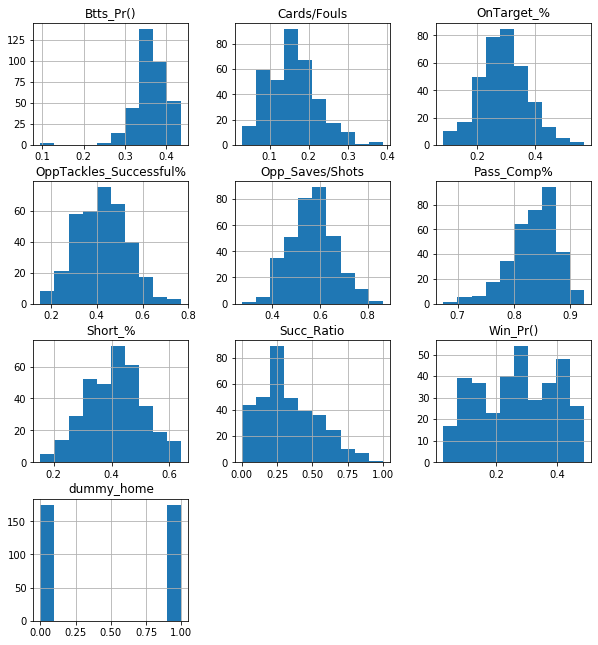

In [22]:
# Having a closer look at the distribution of the data 

model_data.hist(figsize=(10,11));

In [23]:
# Standard Scaler does not need to be performed as data is distributed normally
# However leaving this code in case features are added that need to be scaled normally

from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(X) 

# Final Data

In [24]:
# Only need to run this if you want to standard scale data

# Obtaining model_data1 which has normal y and resetting the index
model_data1 = model_data1.reset_index()
model_data1 = model_data1.drop(['index'], axis=1)

# Creating data frame with standardised X and normal y
model_data = pd.DataFrame(X_standard, columns=feature_names)
model_data = pd.concat([model_data, model_data1['Goals']], axis=1)

In [25]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
OnTarget_%                350 non-null float64
Short_%                   350 non-null float64
Succ_Ratio                350 non-null float64
Pass_Comp%                350 non-null float64
Cards/Fouls               350 non-null float64
OppTackles_Successful%    350 non-null float64
Opp_Saves/Shots           350 non-null float64
dummy_home                350 non-null float64
Win_Pr()                  350 non-null float64
Btts_Pr()                 350 non-null float64
Goals                     350 non-null object
dtypes: float64(10), object(1)
memory usage: 30.2+ KB


In [26]:
model_data

,OnTarget_%,Short_%,Succ_Ratio,Pass_Comp%,Cards/Fouls,OppTackles_Successful%,Opp_Saves/Shots,dummy_home,Win_Pr(),Btts_Pr(),Goals
0,0.529289,2.346795,-0.879030,0.824639,0.040708,0.363965,0.777468,1.0,-1.229266,0.135515,2
1,0.087261,-0.336861,0.556551,0.931332,-1.136780,0.410962,0.191677,1.0,-1.102621,-0.428803,1
2,-0.331502,0.368060,-0.245915,0.325879,-0.053072,1.632872,0.339069,1.0,-0.384966,0.518547,1
3,-0.054819,-1.283677,-0.199018,-0.670221,-0.352342,-0.810949,-0.296312,1.0,0.867546,-1.204445,1
4,-0.977096,2.250271,-1.559042,-0.887523,-1.469075,0.363965,0.457802,1.0,1.076389,-0.186857,1
5,2.328342,-0.115937,0.400992,1.058036,-0.119145,0.568628,2.099111,1.0,0.002956,1.219821,3
6,2.573668,1.635672,-1.559042,-2.948891,0.222610,0.899726,0.033756,1.0,1.611329,-2.761079,2
7,0.445845,0.593047,0.344991,0.781076,0.247127,-1.247346,-0.356761,1.0,-1.445139,-0.248617,1
8,-0.054819,-1.770235,-1.126307,-1.479508,0.128627,1.133000,0.695268,1.0,0.902431,-0.544854,3
9,0.928192,-0.963261,-0.369021,-0.570811,-1.270950,-0.132110,-0.545286,1.0,0.512104,-0.186857,0


In [27]:
# We are going to create four different datasets which all have different Y values
# The features are going to remain the same, but it is the target variable that is changing per scenario
# Goaless (0,1), OneGoal (0,1), TwoGoals (0,1), ThreeGoals+ (0,1)

In [28]:
# Creating the columns as discussed above

# Goalless
Goalless = model_data
Goalless['Goals'] = pd.to_numeric(Goalless['Goals'])
Goalless['Goalless'] = Goalless['Goals'].apply(lambda x: 1 if (x == 0) else 0)
Goalless = Goalless.drop(['Goals'], axis=1)

#One Goal
OneGoal = model_data
OneGoal['Goals'] = pd.to_numeric(OneGoal['Goals'])
OneGoal['OneGoal'] = OneGoal['Goals'].apply(lambda x: 1 if (x == 1) else 0)
OneGoal = OneGoal.drop(['Goals'], axis=1)

# Two Goals
TwoGoals = model_data
TwoGoals['Goals'] = pd.to_numeric(TwoGoals['Goals'])
TwoGoals['TwoGoals'] = TwoGoals['Goals'].apply(lambda x: 1 if (x == 2) else 0)
TwoGoals = TwoGoals.drop(['Goals'], axis=1)

# Three Goals Plus
ThreeGoalsPlus = model_data
ThreeGoalsPlus['Goals'] = pd.to_numeric(ThreeGoalsPlus['Goals'])
ThreeGoalsPlus['ThreeGoals+'] = ThreeGoalsPlus['Goals'].apply(lambda x: 1 if (x > 2.5) else 0)
ThreeGoalsPlus = ThreeGoalsPlus.drop(['Goals'], axis=1)

# Final dataframes
Goalless = Goalless
OneGoal = OneGoal.drop(['Goalless'], axis =1)
TwoGoals = TwoGoals.drop(['Goalless', 'OneGoal'], axis =1)
ThreeGoalsPlus = ThreeGoalsPlus.drop(['Goalless', 'OneGoal', 'TwoGoals'], axis =1)
model_data = model_data.drop(['Goalless', 'OneGoal', 'TwoGoals', 'ThreeGoals+'], axis =1)

In [29]:
# Export data frames to use for machine learning in BigML and jupyter notebooks
Goalless.to_csv('../final_files/Goalless.csv')
OneGoal.to_csv('../final_files/OneGoal.csv')
TwoGoals.to_csv('../final_files/TwoGoals.csv')
ThreeGoalsPlus.to_csv('../final_files/ThreeGoalsPlus.csv')
model_data.to_csv('../final_files/Final_Model_Data.csv')